# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Required imports

import pickle
import csv

import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import numpy as np

from operator import itemgetter

import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import os

In [2]:
#
# Loading data from files
#

# Load pickled data
kFolder = 'traffic-signs-data'
kIthImage = 1

training_file = kFolder + '/train.p'
testing_file = kFolder + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_all, y_train_all = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Here we have the option to only use a subset of the data (via kIthImage),
# mainly for testing the chain in terms of errors. The whole data set takes a long time
# on a normal cpu, hence this was a reasonable approach to get feedback about the working chain.
# Note: of course a reduced data set is reducing the training accuracy!
X_train_all = X_train_all[0:len(X_train_all):kIthImage]
y_train_all = y_train_all[0:len(y_train_all):kIthImage]

del train
del test

In [3]:
#
# Loading data from csv
#

# Load the CSV file
signs_dict = {}

with open(kFolder + '/signnames.csv', 'r') as file:
    data = csv.reader(file)
    
    for row in data:
        if row[0] == 'ClassId': continue
        signs_dict[format(int(row[0]), '02d')] = row[1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
#
# Data evaluation
#

n_train = len(X_train_all)
n_test = len(X_test)
image_shape = X_train_all[0].shape
n_classes = len(set(y_train_all))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

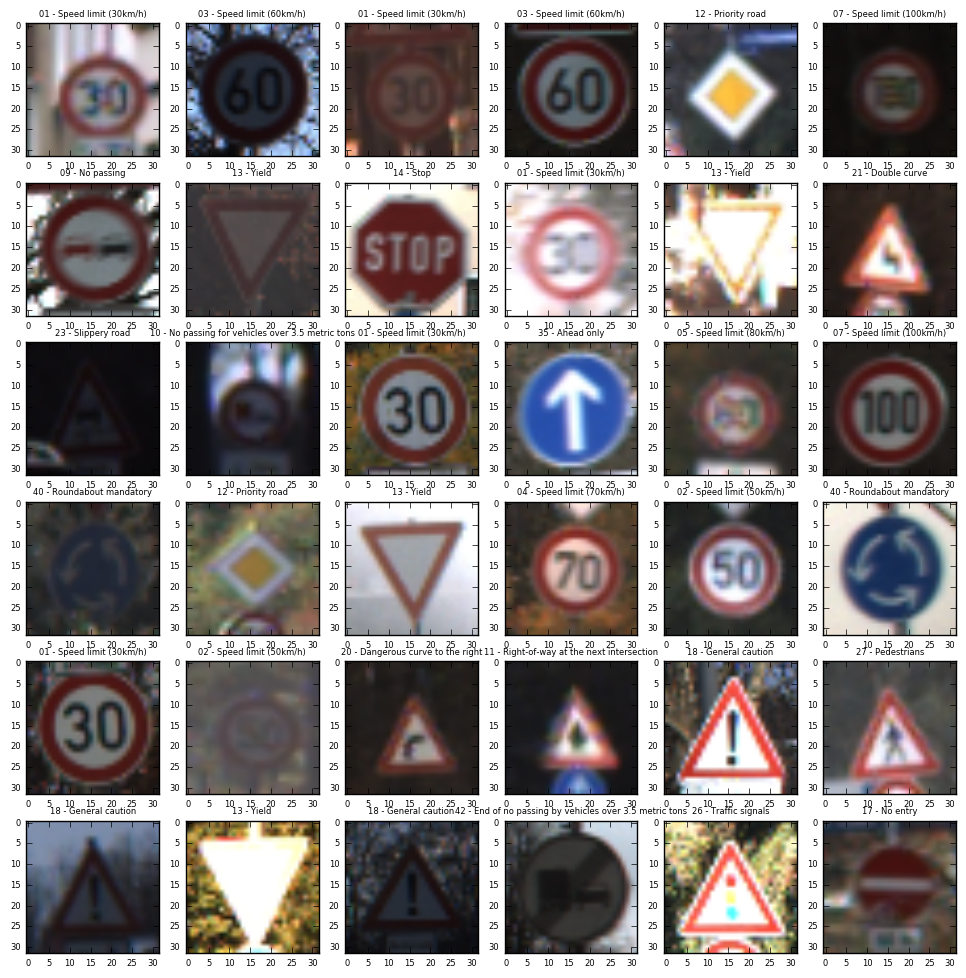

In [5]:
#
# Data exploaration by plotting
#

kNumOfImages = 36
kNumOfImagesPerRow = np.sqrt(kNumOfImages)
kFontSize = 6
kFigSize = 12

plt.figure(figsize=(kFigSize, kFigSize))
plt.rcParams['xtick.labelsize'] = kFontSize
plt.rcParams['ytick.labelsize'] = kFontSize
    
for i in range(1, kNumOfImages + 1):
    index = random.randint(0, len(X_train_all) - 1)
    image = X_train_all[index].squeeze()

    ax = plt.subplot(kNumOfImagesPerRow, kNumOfImagesPerRow, i)
    
    id_of_sign = str(format(int(y_train_all[index]), '02d'))
    ax.set_title(id_of_sign + ' - ' + signs_dict[id_of_sign], fontsize = kFontSize)
    
    plt.imshow(image)

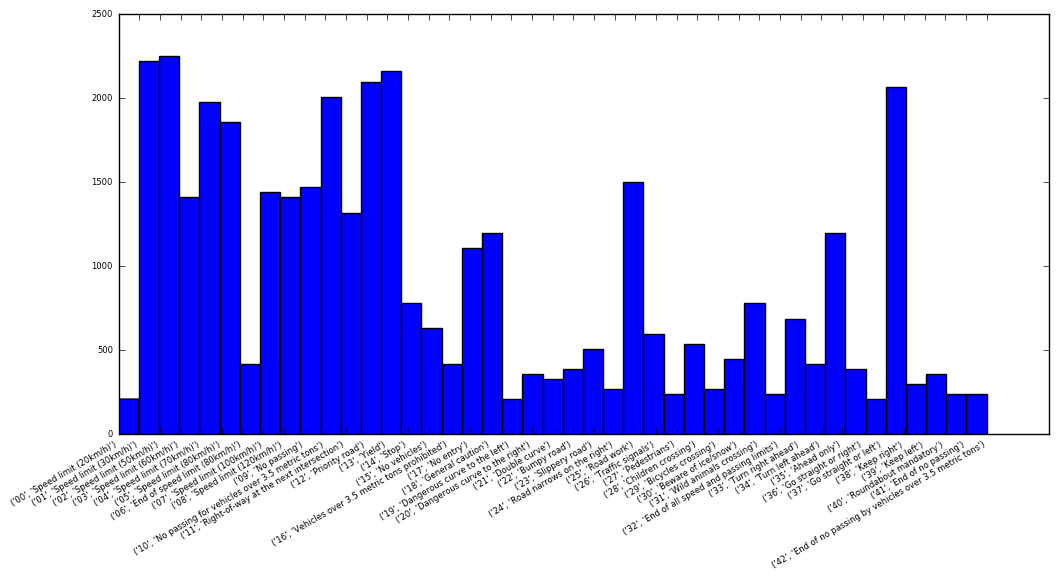

In [6]:
#
# Data histogram
#

# Create the hist data required for the latter fake data generation step
hist_data = np.histogram(y_train_all, n_classes)[0]

fig = plt.figure(figsize=(kFigSize, kFigSize / 2))
sorted_list = sorted(signs_dict.items(), key=itemgetter(0))

_ = plt.hist(y_train_all, n_classes)
_ = plt.xticks(range(n_classes), sorted_list)

fig.autofmt_xdate()

In [7]:
#
# Transormation by getAffineTransform and warpAffine
# Source: http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
#

kAlterationSpan = 4
kHalfAlterationSpan = int(kAlterationSpan / 2)
kMaxSize = 32
kValidPadding = kMaxSize - kAlterationSpan

def get_transformation(n_transforms, img):
    rows,cols,ch = img.shape
    
    transformed_images = []
    
    for i in range(n_transforms):
        
        # Define bases points for transformation
        pts1 = np.float32([[kAlterationSpan, kAlterationSpan],  # first point
                           [kValidPadding, kAlterationSpan],    # second point
                           [kValidPadding, kValidPadding]])     # third point
        
        # Define destiation points for transformation
        pts2 = np.float32([[random.randint(-kAlterationSpan, kAlterationSpan), # first poin
                            random.randint(-kAlterationSpan, kAlterationSpan)],
                           
                           [kValidPadding + random.randint(-kHalfAlterationSpan, kHalfAlterationSpan), # second poin
                            random.randint(-kAlterationSpan, kAlterationSpan)],
                           
                           [kValidPadding + random.randint(-kAlterationSpan, kAlterationSpan), # third point
                            kValidPadding + random.randint(-kAlterationSpan, kAlterationSpan)]])

        M = cv2.getAffineTransform(pts1, pts2)
        dst = cv2.warpAffine(img, M, (cols, rows))
        
        transformed_images.append(dst)
        
    return transformed_images

In [8]:
#
# Visualizes a set of images
#

def visualize_images(n_images, images):
    if len(images) < n_images:
        return
    
    fig = plt.figure(figsize=(kFigSize, kFigSize))
    
    for i in range(0, n_images):
        
        index = random.randint(0, len(images) - 1)
        image = images[index].squeeze()

        ax = plt.subplot(np.sqrt(n_images), np.sqrt(n_images), i+1)
        plt.imshow(image)

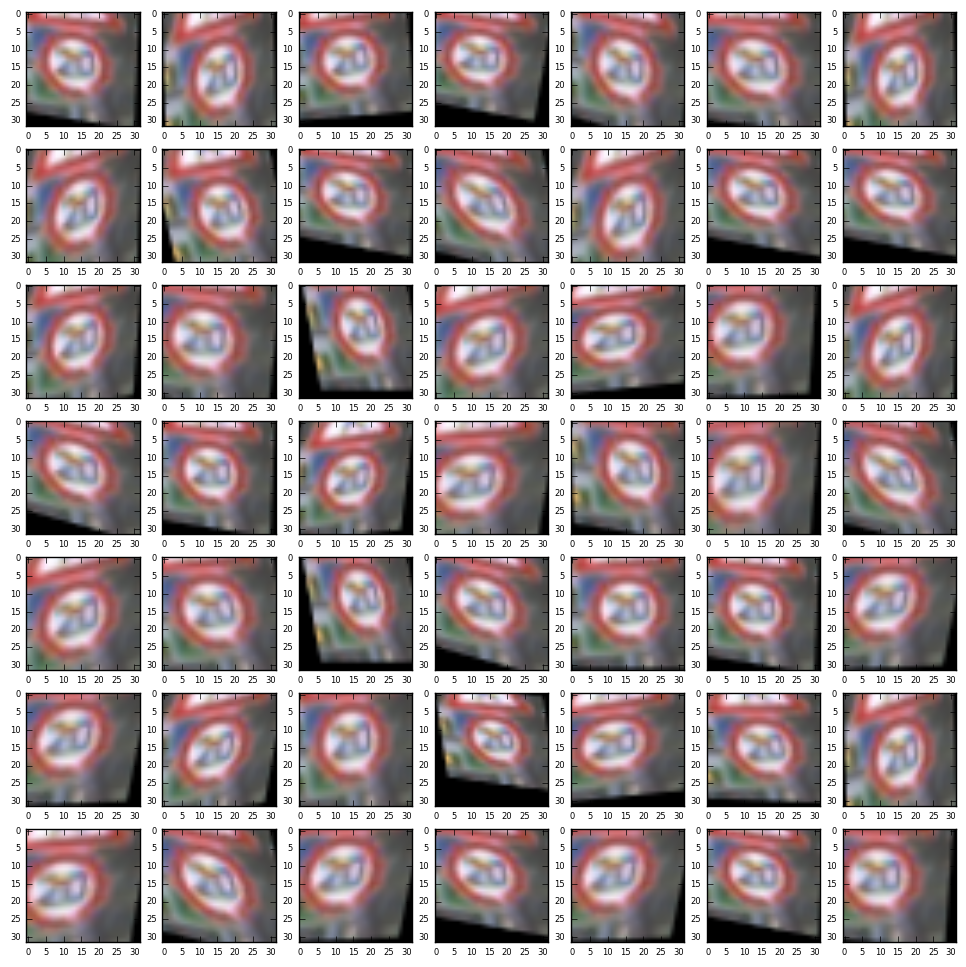

In [9]:
#
# Test the transormation on a example image
#

n_transformations = 49
image = X_train_all[0]

transformed_images = get_transformation(n_transformations, image)

visualize_images(n_transformations, transformed_images)

del transformed_images

Generating transformations ...
Number of transformed images / labels:
13260
13260
Example transformations


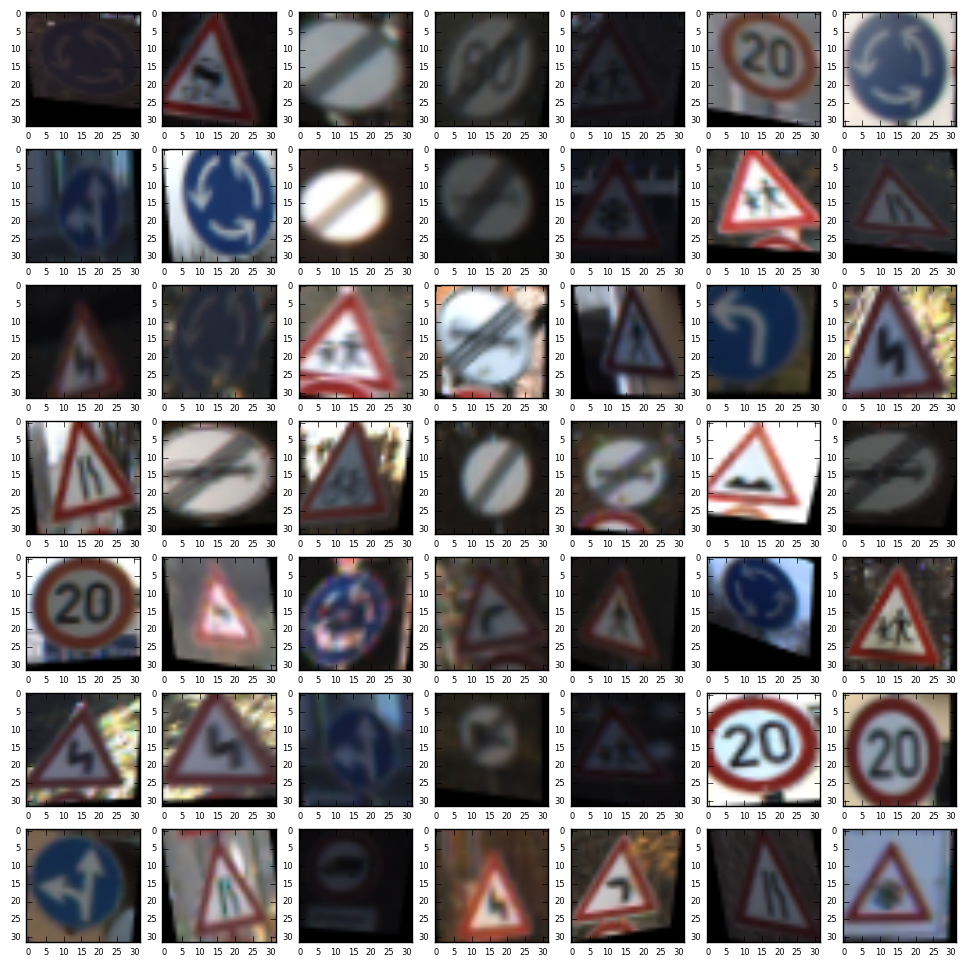

In [10]:
#
# Apply the transformation on images which are very scarce
#

kTreshPercentage = 0.5
kThreshold = max(hist_data) * kTreshPercentage

indices_for_transformation = hist_data < kThreshold

first_index = 0
transformed_images = []
transformed_labels = []

print('Generating transformations ...')

for item, hist_item, shall in zip(enumerate(hist_data), hist_data, indices_for_transformation):
    last_index = first_index + hist_item

    if (shall):
        available = hist_item
        
        desired_transformations = (kThreshold / available) - 1
        desired_transformations = int(desired_transformations)
        
        for image in X_train_all[first_index:last_index]:
            transformations = get_transformation(desired_transformations, image)
            transformed_images += transformations
        
        n_new_labels = desired_transformations * (last_index - first_index)
        
        for index in range(n_new_labels):
            transformed_labels.append(item[0])
        
    first_index = last_index

print('Number of transformed images / labels:')
print(len(transformed_images))
print(len(transformed_labels))

# assert(len(transformed_images) == len(transformed_labels), 'Size missmatch')

# Print examples of transformed images
print("Example transformations")
visualize_images(49, transformed_images)

transformed_images = np.array(transformed_images)
transformed_labels = np.array(transformed_labels)

In [11]:
#
# Append the transformations to our dataset
#

print('Input X / y shapes')
print(X_train_all.shape)
print(y_train_all.shape)

print('Tranformation X / y shapes')
print(transformed_images.shape)
print(transformed_labels.shape)

X_train_all_added = np.append(X_train_all, transformed_images, axis=0)
y_train_all_added = np.append(y_train_all, transformed_labels, axis=0)

del transformed_images
del transformed_labels
del X_train_all
del y_train_all

print('Resulting X / y shape')
print(X_train_all_added.shape)
print(y_train_all_added.shape)

Input X / y shapes
(39209, 32, 32, 3)
(39209,)
Tranformation X / y shapes
(13260, 32, 32, 3)
(13260,)
Resulting X / y shape
(52469, 32, 32, 3)
(52469,)


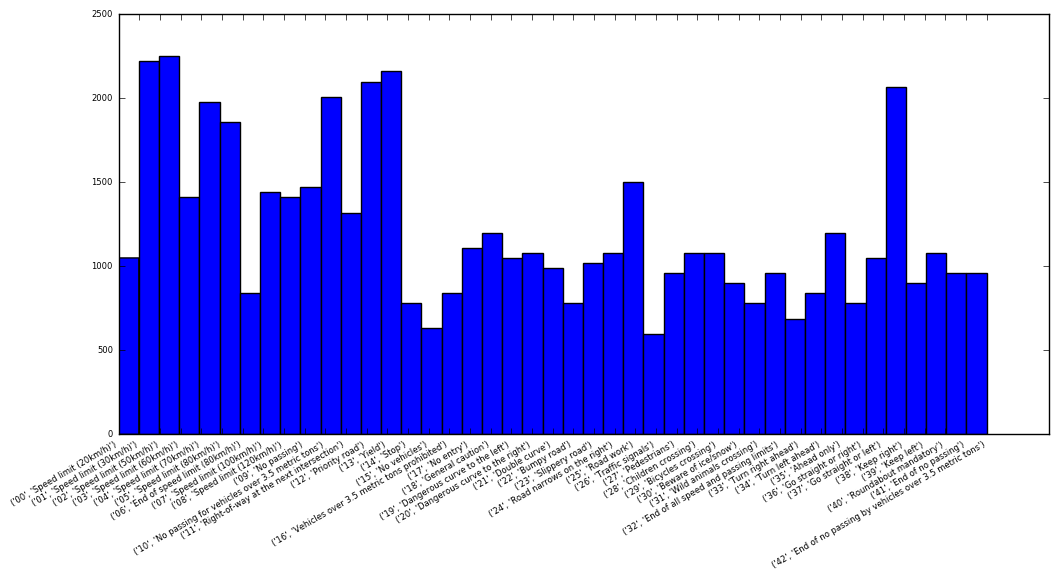

In [12]:
#
# New Data histogram
#

from operator import itemgetter

fig = plt.figure(figsize=(kFigSize, kFigSize/2))
sorted_list = sorted(signs_dict.items(), key=itemgetter(0))

_ = plt.hist(y_train_all_added, n_classes)
_ = plt.xticks(range(n_classes), sorted_list)

fig.autofmt_xdate()

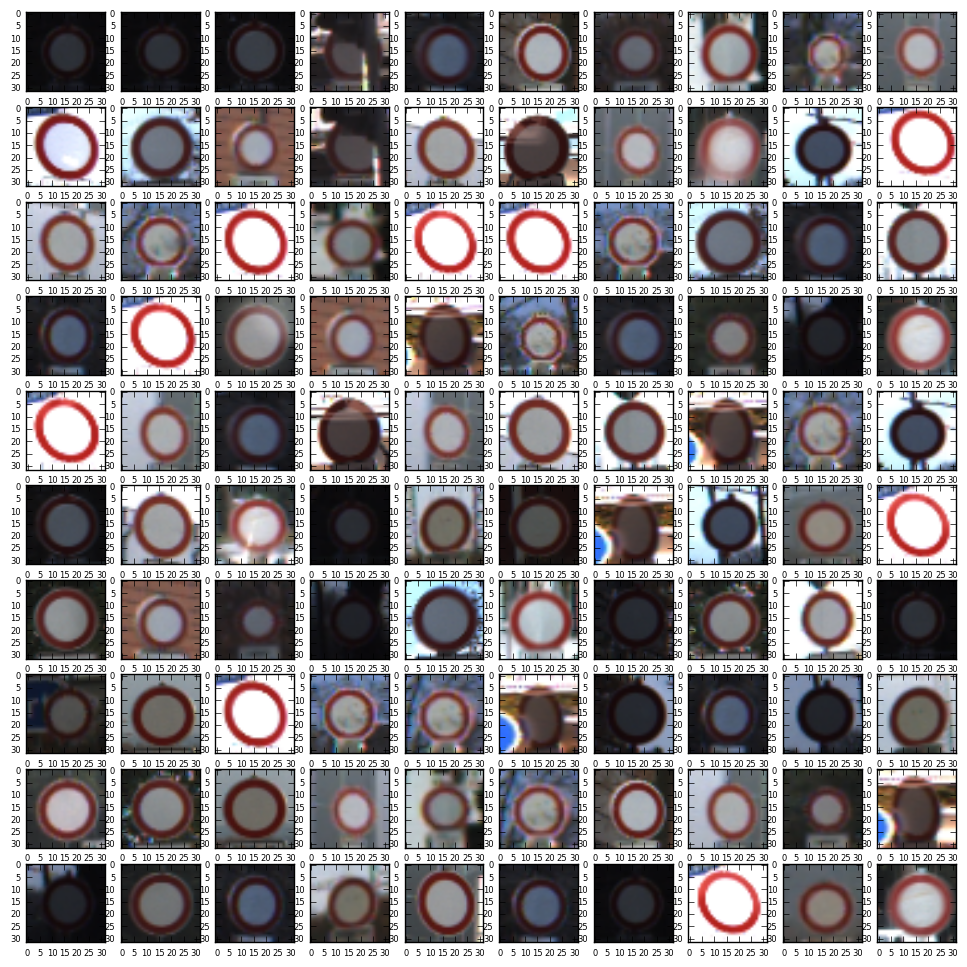

In [13]:
#
# Visualize a certain class id to verify we havent broken anything
#

kIdToVisu = 15

vis = []
for i, image in enumerate(X_train_all_added):
    if (y_train_all_added[i] == kIdToVisu):
        vis.append(image)
        
visualize_images(100, vis)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
#
# Shuffle
#

from sklearn.utils import shuffle

# Shuffle the data
X_train_all_added, y_train_all_added = shuffle(X_train_all_added, y_train_all_added)

Example of a grayscaled image


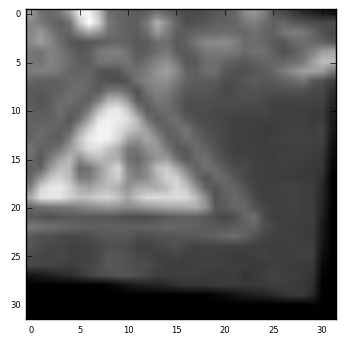

Shape
(32, 32)
Min and Max values of image
0.0
50.774
Histogram


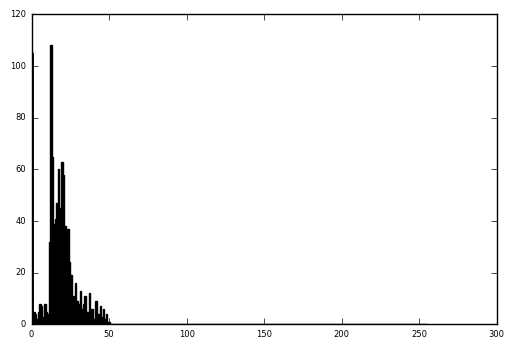

In [15]:
#
# Preprocessing by grayscale
#

def rgb2gray(rgb):
    # Using a formula used by the build-in matlab rgb2ray function
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

X_train_all_gray = []

for image in X_train_all_added:
    image = rgb2gray(image)
    X_train_all_gray.append(image)

# Print first grayscale input
print('Example of a grayscaled image')
_ = plt.imshow(X_train_all_gray[0], cmap="gray")
plt.show()

print('Shape')
print(X_train_all_gray[0].shape)

print('Min and Max values of image')
print(np.min(X_train_all_gray[0]))
print(np.max(X_train_all_gray[0]))

print('Histogram')
_ = plt.hist(X_train_all_gray[0].ravel(), bins=256, range=(0, 255), fc='k', ec='k')
plt.show()

del X_train_all_added

Example of a normalized and equalized image


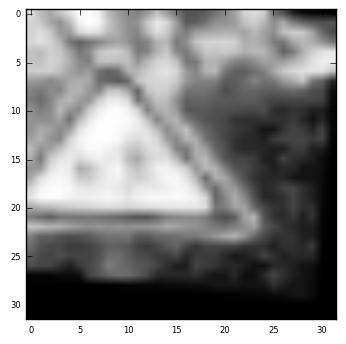

Shape
(32, 32)
Min and Max values of image
-0.398039215686
0.5
Histogram


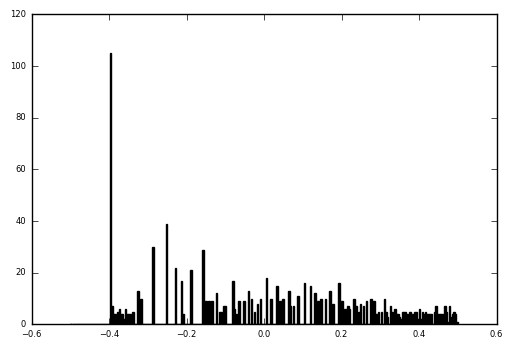

In [16]:
#
# Preprocessing of data by normalization and equalization
#

# Reference: https://www.researchgate.net/publication/
#            281118372_NumPy_SciPy_Recipes_for_Image_Processing_Intensity_Normalization_and_Histogram_Equalization

def normalize(f):
    lmin = float(f.min())
    lmax = float(f.max())
    return np.floor((f - lmin) / (lmax - lmin) * 255.)

# Normalize the images
def equalize(f):
    h = np.histogram(f, bins=np.arange(257))[0]
    H = np.cumsum(h) / float(np.sum(h))
    e = np.floor(H[f.flatten().astype('int')] * 255.0)
    image = e.reshape(f.shape)
    image = (image / 255) - 0.5
    return image

# Emtpy list
X_train_all_gray_norm = []

for image in X_train_all_gray:
    image = normalize(image)
    image = equalize(image)
    X_train_all_gray_norm.append(image)

print('Example of a normalized and equalized image')
_ = plt.imshow(X_train_all_gray_norm[0], cmap = 'gray')
plt.show()

print('Shape')
print(X_train_all_gray_norm[0].shape)

print('Min and Max values of image')
print(np.min(X_train_all_gray_norm[0]))
print(np.max(X_train_all_gray_norm[0]))

print('Histogram')
_ = plt.hist(X_train_all_gray_norm[0].ravel(), bins=256, range=(-0.5, 0.5), fc='k', ec='k')
plt.show()

del X_train_all_gray

In [17]:
#
# Transform into a tensorflow accepted form with 4D
#

X_train_all_gray_norm = np.array(X_train_all_gray_norm)[:, :, :, np.newaxis]

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

The very first attempt was to simply do no pre-processing at all and feed the network (which was taken from the lenet lab) with the data. It resulted in reasonably ok results of about 80% (cross validation, not testing test)

Hence, as the labs and lectures in the nanodgree suggested, preprocessing would be one option
I tried to play around with as many preprocessing techniques that I found valid.

The preprocessing of the data includes several steps:
* Grayscale the image
* Normalize the image (Assure that we have full range from 0 to 255)
* Equalize the image (Assure that the histogram is equally distributed)
* Center the image around 0 mean, that is, bring the image into the range of [-0.5, 0.5]
* Shuffle the data
* Create fake data for under-represented image class (i.e. 20 km/h)

I choose the grayscale as it reduces complexity for the network to learn the actual important stuff (shape and symbols, rather than colors). I assumed that the background colors might influence the actual classifier to learn the signs.

Normalization paired with equalization was a results of the paper linked in the regarded code section. It was suggested to combine both techniques to have a equally distirbuted histogram. 

The centering of the image and its range restictions -0.5 to +0.5 aimed to be more compatible with low weights as it was assumed during the lectures.

A shuffeling of the data is actually performed on each epoch and is very important to prevent the network from learning any ordering of the data set which is not helpful at all.

The fake data was created to prevent the network from dismissing very under-represented image class. The aim was to have a more equal distribution among the classes.

In [18]:
#
# Choose data input set
#

X_used_for_training = X_train_all_gray_norm
y_used_for_training = y_train_all_added

print('Shape of input')
print(X_used_for_training.shape)
print(y_used_for_training.shape)

del X_train_all_gray_norm
del y_train_all_added

Shape of input
(52469, 32, 32, 1)
(52469,)


In [ ]:
#
# Preparation of test, train and validation set
#

### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Split the train set into a train and validation set
kPercentageValidationSet = 0.2
end_of_val_indices = int(len(X_used_for_training) * kPercentageValidationSet)

val_indices = range(0, end_of_val_indices)
train_indices = range(end_of_val_indices, len(X_used_for_training))

X_validation = X_used_for_training[val_indices]
X_train = X_used_for_training[train_indices]

y_validation = y_used_for_training[val_indices]
y_train = y_used_for_training[train_indices]

del X_used_for_training
del y_used_for_training

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The initial data sets provided were already split into "train" and "test".
During the entire training process, the test set is not touched.

The training set undergoes all preprocessing steps including the generation of fake data as decribed in question 1.
It is afterwards split into a train and validation set, whereby 20% of the original train data is used for validation.
The validation set is the basis for evaluating the prediction accuracy on each epoch, but musst not mixed with the testing set which shall only be applied once, once the training accuracy reaches a reasonable level.

The fake data was generated to prevent the model from "ignoring" traffic sign classes which were rare. 
These fake data is generated based on the histogram distribution of all sign classes. If a certain threshold is undershot, we generate additional images and append those to our original data set. 

By doing this, we almost added around 13k images, adding up to 53k images in total (see output of the implementation)

In [20]:
#
# Tensoflow setup
#

kEpochs = 20
kBatchSize = 256
kFilter = 5
kMu = 0
kSigma = 0.01
kLearningRateStart = 0.0050
kLearningRateEnd = 0.0005
kKeepProb = 0.5

In [21]:
#
# Definition of layers including depth, weights and biases
#

layer_depth = {
    'in': X_train.shape[3],
    'layer_1': 6,
    'layer_2': 16,
    'layer_3': 120,
    'layer_4': 84
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [kFilter, kFilter, layer_depth['in'], layer_depth['layer_1']], kMu, kSigma)),
    
    'layer_2': tf.Variable(tf.truncated_normal(
        [kFilter, kFilter, layer_depth['layer_1'], layer_depth['layer_2']], kMu, kSigma)),
    
    'layer_3': tf.Variable(tf.truncated_normal(
        [kFilter * kFilter * layer_depth['layer_2'], layer_depth['layer_3']], kMu, kSigma)),
    
    'layer_4': tf.Variable(tf.truncated_normal(
        [layer_depth['layer_3'], layer_depth['layer_4']], kMu, kSigma)),
    
    'out': tf.Variable(tf.truncated_normal(
        [layer_depth['layer_4'], n_classes]))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
    'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

In [22]:
#
# Some helper methods to ease access to convolotion and maxpooling
#

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(
        x,
        W,
        strides=[1, strides, strides, 1],
        padding='VALID')

    x = tf.nn.bias_add(x, b)

    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # Applies max pooling
    max_pooled = tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

    return max_pooled

In [23]:
#
# The actual architecture model
#

def LeNet(x, keep_prob):
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    print(conv1)

    # Activation.
    conv1 = tf.nn.relu(conv1)
    print(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    print(conv1)
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)
    print(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    print(conv2)

    # Activation.
    conv2 = tf.nn.relu(conv2)
    print(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    print(conv2)
        
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)
    print(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    print(fc0)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1   = tf.add(tf.matmul(fc0, weights['layer_3']), biases['layer_3'])
    print(fc1)

    # Activation.
    fc1 = tf.nn.relu(fc1)
    print(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2   = tf.add(tf.matmul(fc1, weights['layer_4']), biases['layer_4'])
    print(fc2)

    # Activation.
    fc2 = tf.nn.relu(fc2)
    print(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(logits)

    return logits

In [24]:
#
# Create the architecture
#

image_shape = X_train[0].shape

shape = (None,) + image_shape

x = tf.placeholder(tf.float32, shape)
y = tf.placeholder(tf.int32, (None))
learning_rate = tf.placeholder(tf.float32, shape=[])
keep_prob = tf.placeholder(tf.float32, shape=[])

one_hot_y = tf.one_hot(y, n_classes)

print('The model\'s architecture looks like:')
logits = LeNet(x, keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

The model's architecture looks like:
Tensor("Relu:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("Relu_1:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 6), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 6), dtype=float32)
Tensor("Relu_2:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("Relu_3:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 5, 5, 16), dtype=float32)
Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)
Tensor("Add:0", shape=(?, 120), dtype=float32)
Tensor("Relu_4:0", shape=(?, 120), dtype=float32)
Tensor("Add_1:0", shape=(?, 84), dtype=float32)
Tensor("Relu_5:0", shape=(?, 84), dtype=float32)
Tensor("Add_2:0", shape=(?, 43), dtype=float32)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

The architecture mostly equals the LeNet architecture which was introduced in a previous lession.
From the beginning this was the suggestion to use it as a good starting point.
Minor adaption were conducted in the input and output layer dimensions.

The overall architecture is hence as follows:

Layer 1: 
- Convolution. Input = 32x32x1. Output = 28x28x6.
- Relu Activation.
- Pooling. Input = 28x28x6. Output = 14x14x6.
- Dropout with keep probability of 0.75

Layer 2: 
- Convolution. Output = 10x10x16.
- ReluActivation.
- Pooling. Input = 10x10x16. Output = 5x5x16.
- Dropout with keep probability of 0.75

Bridge Layer:
- Flatten. Input = 5x5x16. Output = 400.

Layer 3:
- Fully Connected with linear activation. Input = 400. Output = 120.
- Relu Activation.

Layer 4: 
- Fully Connected with linear activation. Input = 120. Output = 84.
- Relu Activation.

Layer 5:
- Fully Connected with linear activation. Input = 84. Output = 43.

The final layer's output represents the 43 traffic sign classes

In [25]:
#
# Evaluation
#

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    
    print("Evaluating ...")
    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, kBatchSize):
        batch_x, batch_y = X_data[offset:offset + kBatchSize], y_data[offset:offset + kBatchSize]
        
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, 
                                                           y: batch_y, 
                                                           keep_prob : 1.0})
        
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

In [26]:
#
# Training
#

def train_network(X_train, y_train, 
                  X_validation, y_validation, 
                  training_operation, 
                  kBatchSize, kEpochs, 
                  kLearningRateStart, kLearningRateEnd): 
        
    num_examples = len(X_train)
    
    for i in range(kEpochs):
        print("Epoch #{} ...".format(i+1))
        
        X_train, y_train = shuffle(X_train, y_train)
        
        rate = kLearningRateStart - i * ((kLearningRateStart - kLearningRateEnd) / (kEpochs - 1))
        
        print("Training with learning rate {:.4f}".format(rate) + ' ...')
        
        for offset in range(0, num_examples, kBatchSize):
            end = offset + kBatchSize
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y, 
                                                    learning_rate: rate, 
                                                    keep_prob : kKeepProb})

        validation_accuracy = evaluate(X_validation, y_validation)
        
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))

In [27]:
#
# Session saver
#

kSaverFolder = "saver"
kSaverName = 'model'

def save_model(sess, saver):
    print('Saving model to filename: ' + kSaverName + ' ...')
        
    saver.save(sess, kSaverName)
    
    print("Model was saved")

In [28]:
#
# Session loader
#

def load_model(sess):
    print('Loading model from filename: ' + kSaverName + ' ...')
    
    # Load previous data
    loader = tf.train.import_meta_graph(kSaverName + '.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    print("Model was loaded")

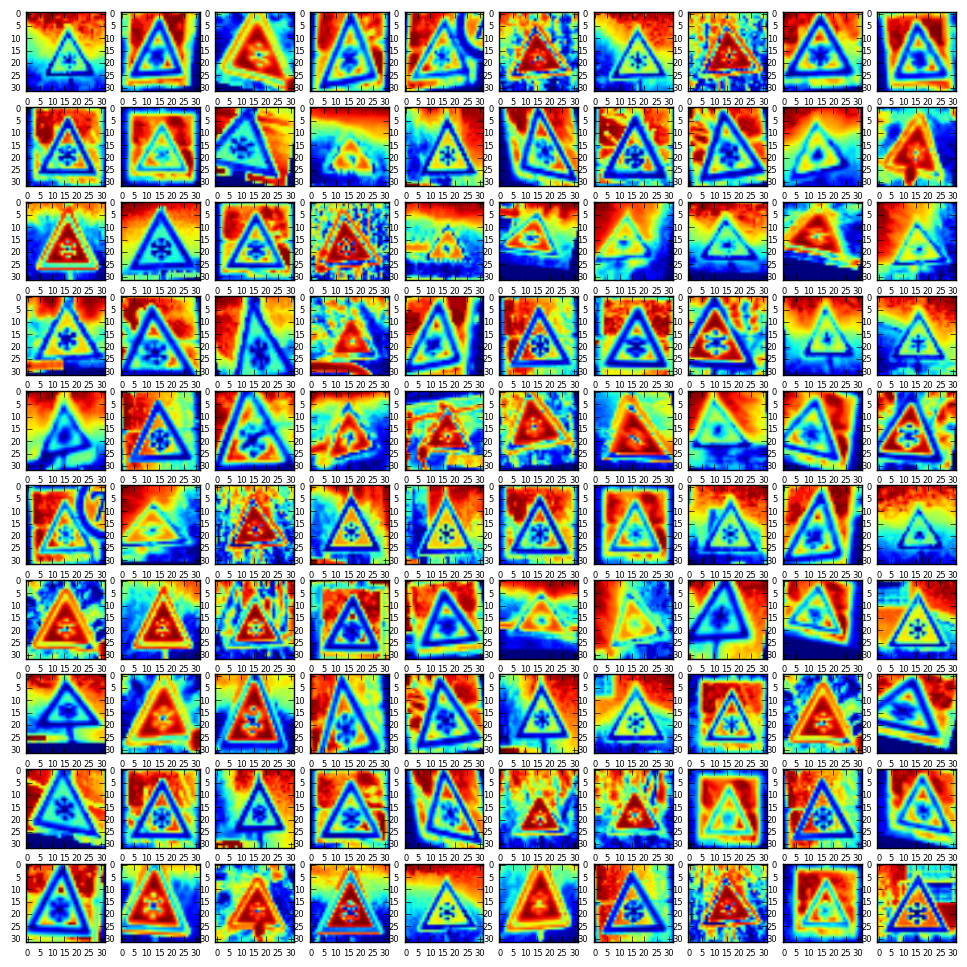

In [29]:
#
# Visualize a certain class id to verify we havent broken anything
#

kIdToVisu = 30

vis = []
for i, image in enumerate(X_train):
    if (y_train[i] == kIdToVisu):
        vis.append(image)
        
visualize_images(100, vis)

In [30]:
#
# Training main method
#

print('Training Parameters:')
print('kEpochs ' + str(kEpochs))
print('kBatchSize ' + str(kBatchSize))
print('kMu ' + str(kMu))
print('kSigma ' + str(kSigma))
print('kLearningRateStart ' + str(kLearningRateStart))
print('kLearningRateEnd ' + str(kLearningRateEnd))
print('kKeepProb ' + str(kKeepProb))
print('')
print('Number of images in training set ' + str(len(X_train)))
print('Number of images in test set ' + str(len(X_test)))
print('')

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    train_network(X_train, 
                  y_train, 
                  X_validation, 
                  y_validation, 
                  training_operation, 
                  kBatchSize, 
                  kEpochs,
                  kLearningRateStart, 
                  kLearningRateEnd)

    # Saver object
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
        
    save_model(sess, saver)

Training Parameters:
kEpochs 20
kBatchSize 256
kMu 0
kSigma 0.01
kLearningRateStart 0.005
kLearningRateEnd 0.0005
kKeepProb 0.5

Number of images in training set 41976
Number of images in test set 12630

Epoch #1 ...
Training with learning rate 0.0050 ...
Evaluating ...
Validation Accuracy = 0.640
Epoch #2 ...
Training with learning rate 0.0048 ...
Evaluating ...
Validation Accuracy = 0.754
Epoch #3 ...
Training with learning rate 0.0045 ...
Evaluating ...
Validation Accuracy = 0.792
Epoch #4 ...
Training with learning rate 0.0043 ...
Evaluating ...
Validation Accuracy = 0.828
Epoch #5 ...
Training with learning rate 0.0041 ...
Evaluating ...
Validation Accuracy = 0.837
Epoch #6 ...
Training with learning rate 0.0038 ...
Evaluating ...
Validation Accuracy = 0.846
Epoch #7 ...
Training with learning rate 0.0036 ...
Evaluating ...
Validation Accuracy = 0.845
Epoch #8 ...
Training with learning rate 0.0033 ...
Evaluating ...
Validation Accuracy = 0.864
Epoch #9 ...
Training with learning 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The type of optimizer is the AdamOptimizer.  I used the already suggested optimizer from the LeNet lab and did not go into details of benefits / drawbacks of this optimizer. However, the cofluence forum suggested to use this optimizer if a training rate decay approach was used.

The evaluation was done using the already known softmax cross entropy with logits method.

I choosed 20 Epochs for the initial training and implemented the code such that I can reload the already trained model and add more epochs, which is set to 10 currently. However, the trained epochs revealed a good trade off between overfitting and underfitting, as one can see at that point where the accuracy does not change any more.

As a batch size I used 256 as empirically this resulted in reasonable results.

For the weight initialization I used a mean of 0 and a sigma of 0.01

For the learning rate I used a learning rate decay method which stated at 0.005 and went down to 0.0005.
In my first implementation I simply used a learning rate of 0.001, but since I found it interesting to play around with the learning rate and it produces reasonable results, I kept the approach.

The dropout layers where also added quite late. For the training I set it to 0.5 since I already got good results without dropout, but since I did not had any countermeaures for overfitting I found it reasonable to add those.

For the evaluation the keep prob is set to 1 again (it first was wrongly left to 0.5 which caused weird results)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The approach was basically trying to get the system running as soon as possible with basic results and tweak the hyper paramaters in the following steps. The tweaking of the params was trial and error, since even small changes in the params reveal sometimes very different output (e.g. the learning rate)

Hence, the already introduced and suggested LeNet network was the first choice, since it already went well with similiar sized images (32x32). 
Also the idea behind the different layers was appropriate:
- from the very deep layers which tray to detect edges and panes, 
- up to the higher order layers which combine these simple shapes into more complex ones such as corners and curves,
- and finally reaching the highest layers which are able to combine all these to complex shapes as required for the traffic signs.

After receiving the first results, I participated in discussion in the confluence and slack channele. There was suggested to add a learning rate decay, more comprehensive preprocessing steps and some dopout layers which I step for step implemented and compared the results.


In [31]:
#
# Explore the saved data set's variables
#

sess = tf.Session()

load_model(sess)

all_vars = tf.trainable_variables()
for v in all_vars:
    print(v.name)

Loading model from filename: model ...
Model was loaded
Variable:0
Variable_1:0
Variable_2:0
Variable_3:0
Variable_4:0
Variable_5:0
Variable_6:0
Variable_7:0
Variable_8:0
Variable_9:0
Variable:0
Variable_1:0
Variable_2:0
Variable_3:0
Variable_4:0
Variable_5:0
Variable_6:0
Variable_7:0
Variable_8:0
Variable_9:0


In [32]:
#
# Continue training (optional)
# Here we can load the previously trained model and continue with more epochs
#

kEpochsCtd = 10

with tf.Session() as sess:
    
    load_model(sess)
    train_network(X_train, y_train, 
                  X_validation, y_validation, 
                  training_operation, 
                  kBatchSize, kEpochsCtd, 
                  kLearningRateEnd, kLearningRateEnd)
    
    # Saver object
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
            
    save_model(sess, saver)

Loading model from filename: model ...
Model was loaded
Epoch #1 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.915
Epoch #2 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.912
Epoch #3 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.914
Epoch #4 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.916
Epoch #5 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.916
Epoch #6 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.918
Epoch #7 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.918
Epoch #8 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.919
Epoch #9 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy = 0.918
Epoch #10 ...
Training with learning rate 0.0005 ...
Evaluating ...
Validation Accuracy =

In [33]:
#
# Preprocess the test set
#

X_test_all_gray = []

for image in X_test:
    image = rgb2gray(image)
    X_test_all_gray.append(image)
    
X_test_all_gray_norm = []

for image in X_test_all_gray:
    image = normalize(image)
    image = equalize(image)
    X_test_all_gray_norm.append(image)
    
# Transform into a tensorflow accepted form with 4D
X_test_all_gray_norm = np.array(X_test_all_gray_norm)[:, :, :, np.newaxis]

del X_test_all_gray

In [34]:
#
# Validate the trained network
#

with tf.Session() as sess:
    
    load_model(sess)
    
    # Here we use the up to now never touched and seen test set.
    # Note that indeed this test set has to undergo the same preprocessing steps as the training set
    test_accuracy = evaluate(X_test_all_gray_norm, y_test)
    
    # The final test accuracy!
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Loading model from filename: model ...
Model was loaded
Evaluating ...
Test Accuracy = 0.881


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [35]:
#
# Load the images
#

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

Number of images 10


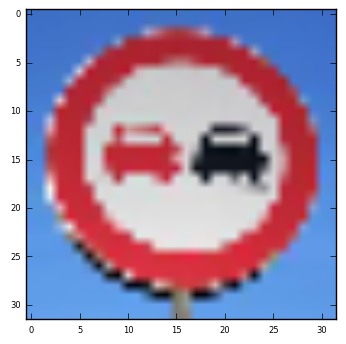

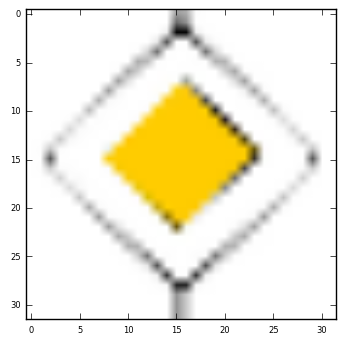

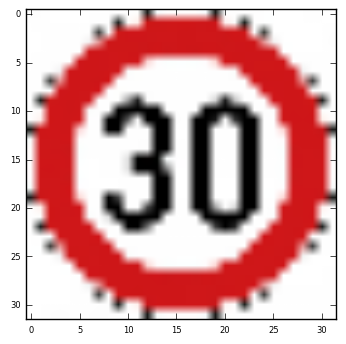

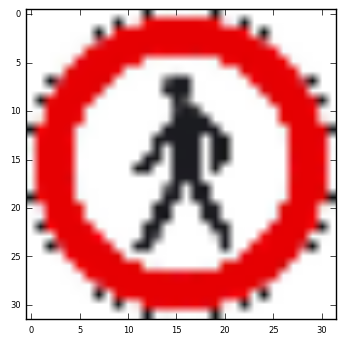

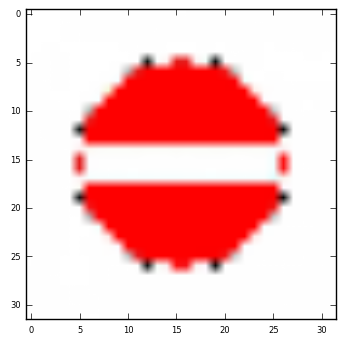

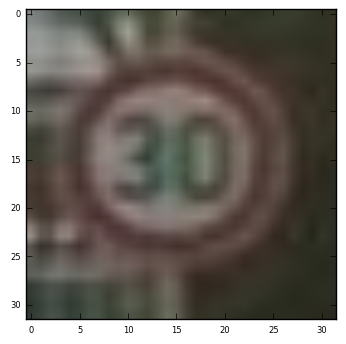

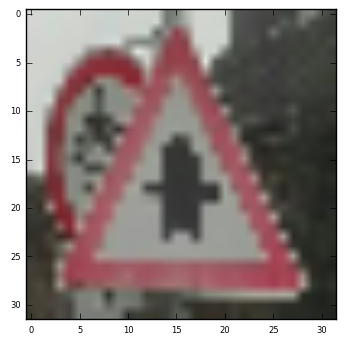

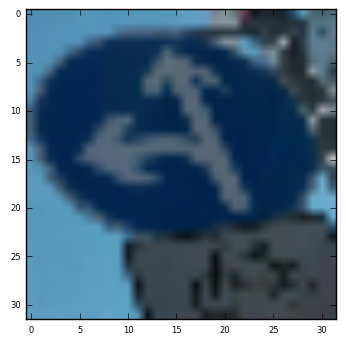

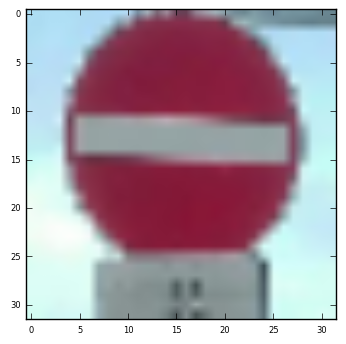

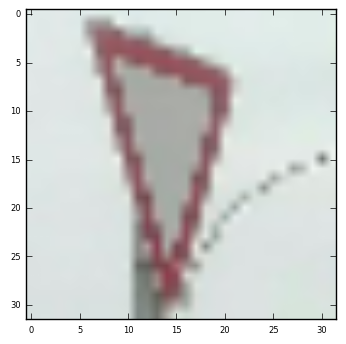

In [36]:
#
# Load the "easy" images from google
#

kFolder = 'own-signs'
kFolderHard = 'own-signs-hard'

images = load_images_from_folder(kFolder)
images.extend(load_images_from_folder(kFolderHard))

print('Number of images ' + str(len(images)))

own_images = []

for img in images:
    img = cv2.resize(img, (32, 32)) 
    _ = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    _ = plt.show()
    own_images.append(img)

# Manually add the labels
# The easy set
own_images_labels = []
own_images_labels.append('09') # no pass
own_images_labels.append('12') # prio
own_images_labels.append('01') # 30
own_images_labels.append('27') # pedestrians
own_images_labels.append('17') # closes

# The hard set
own_images_labels.append('01') # 30
own_images_labels.append('11') # Right of way
own_images_labels.append('34') # left + ahead
own_images_labels.append('09') # no pass
own_images_labels.append('13') # yield

Shapes of own images data set
(10, 32, 32, 1)
(10,)


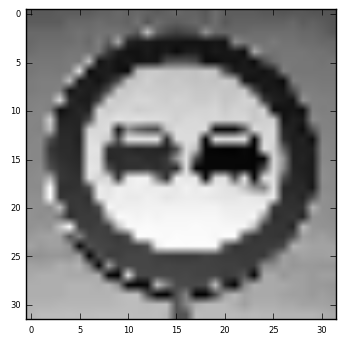

In [37]:
#
# Preprocess the test set
#

own_images_gray = []

for image in own_images:
    image = rgb2gray(image)
    own_images_gray.append(image)
    
own_images_gray_norm = []

for image in own_images_gray:
    image = normalize(image)
    image = equalize(image)
    own_images_gray_norm.append(image)

del own_images_gray

_ = plt.imshow(own_images_gray_norm[0], cmap = 'gray')

# Transform into a tensorflow accepted form with 4D
own_images_gray_norm = np.array(own_images_gray_norm)[:, :, :, np.newaxis]
own_images_labels = np.array(own_images_labels)

print('Shapes of own images data set')
print(own_images_gray_norm.shape)
print(own_images_labels.shape)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I used two sets of images:

First, I used five traffic signs from simply using google image search.
Those five choosen ones were considered "easy" as there are is no particular noise in the base image.
The resizing introduces some artifacts which I did not change since it somewhat introduces some noise.

All images have to be put into the preprocessing pipeline to make them ready for the neural net.

Second, I made pictures of traffic signs while walking or driving and tested them in my system.

Those pictures have a lot of background stuff and are not exactly centralized. They also show some transformation as I did not take the picture while standing directly in front of the image.

Hence, i anticipate those images to have a lower accuracy than the one from google.


In [38]:
#
# Run the predictions
#

with tf.Session() as sess:
    
    load_model(sess)
    test_accuracy = evaluate(own_images_gray_norm[0:5], own_images_labels[0:5])
    test_accuracy_hard = evaluate(own_images_gray_norm[5:10], own_images_labels[5:10])
    
    lg = sess.run(logits, feed_dict={x: own_images_gray_norm, y: own_images_labels, keep_prob : 1})
    oh = sess.run(one_hot_y, feed_dict={y: own_images_labels})
    
    print("Predicted vs. Expected")
    print(sess.run(tf.argmax(lg, 1)))
    print(sess.run(tf.argmax(oh, 1)))
    print("")
    
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Accuracy Hard = {:.3f}".format(test_accuracy_hard))

Loading model from filename: model ...
Model was loaded
Evaluating ...
Evaluating ...
Predicted vs. Expected
[ 9 12  1 25 17  1 11 37 35 36]
[ 9 12  1 27 17  1 11 34  9 13]

Test Accuracy = 0.800
Test Accuracy Hard = 0.400


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The images which were "easy" to classify were classified correctly in 80% of all case (4 out of 5). They do contain less disturbing background and less noise. This indicates that - despite the network has never seen exact those images - the network is reasonably trained to detect the most important features of an image. However, a 80% classification rate indicates that the model is not yet good enough to generalize to completly uknnown images and must be further improved.

The "hard" images (taken by myself) are not all correctly classified as they do contain a lot of background  and noise. We achieve an accuracy of only 40% (2 out of 5) here. This number is quite low, indicating that the model is not yet prepared enough to generalize images and might be overfitted (see also question 6 for explainations).

Loading model from filename: model ...
Model was loaded


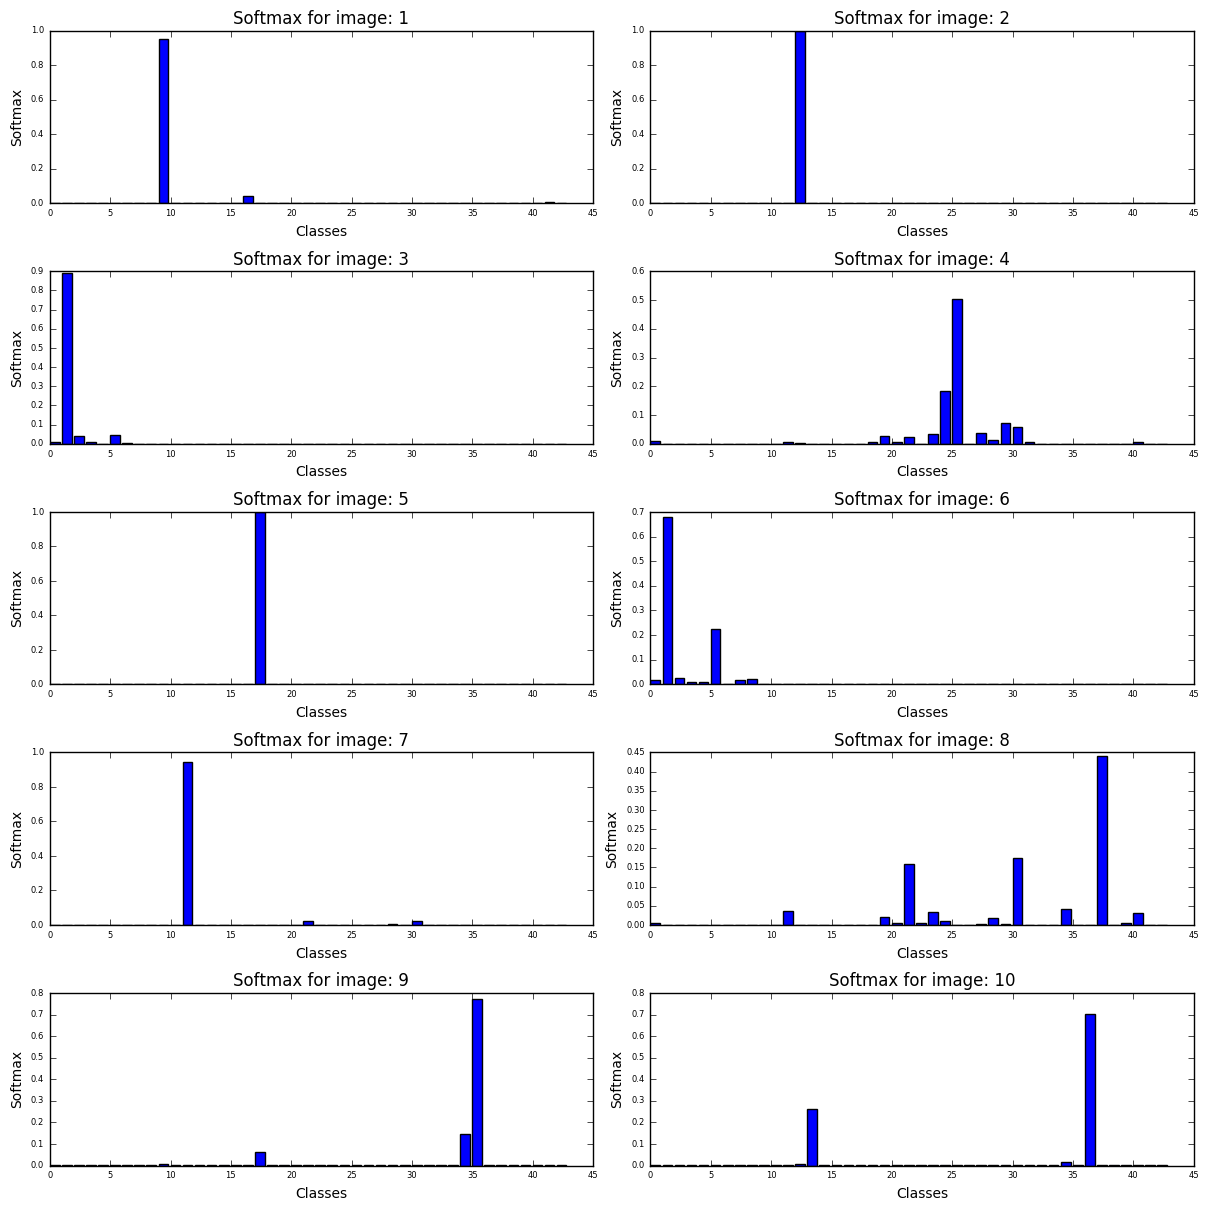

In [39]:
#
# Visualize the softmax probabilities
#

with tf.Session() as sess:
    
    load_model(sess)

    softmax = tf.nn.softmax(logits)
    softmax_out = sess.run(softmax, feed_dict={x: own_images_gray_norm, 
                                               y: own_images_labels, 
                                               keep_prob : 1})
    
    fig = plt.figure(figsize=(kFigSize, kFigSize))
    
    for i in range(0, 10):
        plt.subplot(5, 2, i+1)
        plt.bar(np.arange(n_classes), softmax_out[i])
        plt.title("Softmax for image: " + str(i+1))
        plt.xlabel("Classes")
        plt.ylabel("Softmax")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

Loading model from filename: model ...
Model was loaded
Cross entropy Visualization (Error measure)


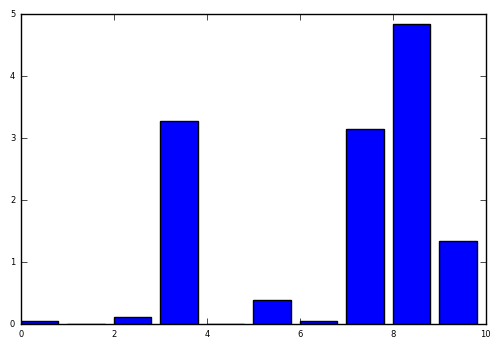


Logits for first classified image (shall be 09)


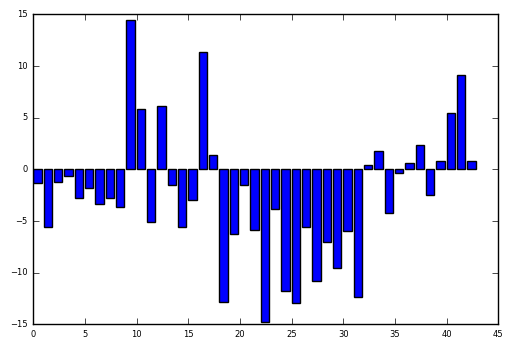


Top 5 of logits

TopKV2(values=array([[ 14.47995663,  11.36656189,   9.18454933,   6.16253662,
          5.85778189],
       [ 29.67699814,  12.77546787,   7.60098648,   6.3406601 ,
          4.64782953],
       [ 10.69043827,   7.74807501,   7.62812996,   6.25751686,
          5.99276733],
       [  5.50564241,   4.4866147 ,   3.54415703,   3.34040093,
          2.90609884],
       [ 22.81378937,  10.55540276,   8.5947094 ,   7.68696451,
          5.35256386],
       [  9.474473  ,   8.37482166,   6.1643877 ,   5.95882702,
          5.80613327],
       [  9.43330956,   5.78758526,   5.70725679,   3.74446297,
          3.42823315],
       [  4.7956233 ,   3.8697989 ,   3.78070879,   2.45497561,
          2.33512735],
       [ 10.08482742,   8.40400982,   7.5770669 ,   5.49350929,
          4.74362278],
       [  6.9586153 ,   5.96652889,   3.29309607,   2.07434845,
          1.58807707]], dtype=float32), indices=array([[ 9, 16, 41, 12, 10],
       [12, 40, 13, 36,  7],
       [ 1,  5,

In [40]:
#
# Visualize logits and cross entropy
#

with tf.Session() as sess:
    
    load_model(sess)

    softmax_out = sess.run(cross_entropy, feed_dict={x: own_images_gray_norm, 
                                                     y: own_images_labels, 
                                                     keep_prob : 1})
    
    print("Cross entropy Visualization (Error measure)")
    plt.bar(np.arange(len(own_images_gray_norm)), softmax_out)
    plt.show()
    
    logits_out = sess.run(logits, feed_dict={x: own_images_gray_norm,
                                             y: own_images_labels,
                                             keep_prob : 1})
    
    print("")
    print("Logits for first classified image (shall be " + str(own_images_labels[0]) + ')')
    plt.bar(np.arange(n_classes), logits_out[0])
    plt.show()
    
    
    print("")
    print("Top 5 of logits\n")
    top5 = sess.run(tf.nn.top_k(logits_out, k=5))
    print(top5)
    print(own_images_labels)

In [41]:
print('Predicted vs. ground truth\n')
for row, truth in zip(top5[1], own_images_labels):
    print('Predicted top 5: ' + str(row) + ' \t--> ' + truth)

Predicted vs. ground truth

Predicted top 5: [ 9 16 41 12 10] 	--> 09
Predicted top 5: [12 40 13 36  7] 	--> 12
Predicted top 5: [1 5 2 0 3] 	--> 01
Predicted top 5: [25 24 29 30 27] 	--> 27
Predicted top 5: [17 33 34 36 16] 	--> 17
Predicted top 5: [1 5 2 8 0] 	--> 01
Predicted top 5: [11 30 21 28 23] 	--> 11
Predicted top 5: [37 30 21 34 11] 	--> 34
Predicted top 5: [35 34 17  9 36] 	--> 09
Predicted top 5: [36 13 34 12 14] 	--> 13


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

By applying the top_k on the logits (which contain the resulting 'probabilities' for each class, in most cases where the prediction was initially wrong, it at least mostly contains the correct class id in the top 5 softmaxes.

These are the exact results.

"Easy" Set
* Predicted top 5: [ 9 16 41 12 10] 	--> 09 was first
* Predicted top 5: [12 40 13 36  7] 	--> 12 was first
* Predicted top 5: [1 5 2 0 3] 	        --> 01 was first
* Predicted top 5: [25 24 29 30 27] 	--> 27 was fith
* Predicted top 5: [17 33 34 36 16] 	--> 17 was first

"Hard" Set
* Predicted top 5: [1 5 2 8 0] 	        --> 01 was first
* Predicted top 5: [11 30 21 28 23] 	--> 11 was first
* Predicted top 5: [37 30 21 34 11] 	--> 34 was fourth
* Predicted top 5: [35 34 17  9 36] 	--> 09 was fourth
* Predicted top 5: [36 13 34 12 14] 	--> 13 was second

However, when the general cross entropy is high, the chance that the image is within the top 5 is lower, since the network in general is very uncertain.

Interestingly, when classified wrongly, the probablities are all quite low and no "absolute" winner can be obtained. This is different with the correctly classified instances, here the winner class id has a great amount of the overall probability share and a small cross entropy.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.